# **Downloading and Setting up the Dataset**

Installing all the required libs beforehand

In [ ]:
# Install necessary libraries if not already installed
!pip install tensorflow keras opencv-python scikit-learn


Import libs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Authenticating Kaggle API

In [ ]:
# Make a kaggle folder and move the kaggle.json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Downloading the dataset

In [ ]:
# Now download the dataset
!kaggle datasets download -d samaarashidaarbi/dibas-bacterial-colony-dataset

# Unzip it
!unzip dibas-bacterial-colony-dataset.zip -d dataset/


Dataset URL: https://www.kaggle.com/datasets/samaarashidaarbi/dibas-bacterial-colony-dataset
License(s): CC0-1.0
Archive:  dibas-bacterial-colony-dataset.zip
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0001.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0002.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0003.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0004.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0005.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0006.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0007.tif  
  inflating: dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/Acinetobacter.baumanii_0008.tif  
  inflating: dataset/Acinetobacter

 Since our dataset has a few corrupt images, we first filter and remove them

In [ ]:
from PIL import Image
import os

def verify_and_clean(folder_path):
    num_deleted = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Will throw error if image is broken
            except Exception as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)
                num_deleted += 1
    print(f"Deleted {num_deleted} corrupted images.")

# Run it
verify_and_clean('/content/dataset')


Deleted 0 corrupted images.


Now Our dataset is available in *train_path = '/content/dataset'*

Verifying the dataset structure

In [ ]:
import os

# List the folders
for dirname, subdirs, files in os.walk('/content/dataset'):
    print(f"Directory: {dirname}, Subdirectories: {subdirs}, Files: {len(files)}")


Directory: /content/dataset, Subdirectories: ['Enterococcus.faecium', 'Lactobacillus.gasseri', 'Staphylococcus.aureus', 'Clostridium.perfringens', 'Lactobacillus.plantarum', 'Lactobacillus.reuteri', 'Bacteroides.fragilis', 'Staphylococcus.saprophiticus', 'Acinetobacter.baumanii', 'Enterococcus.faecalis', 'Veionella', 'Porfyromonas.gingivalis', 'Listeria.monocytogenes', 'Lactobacillus.casei', 'Escherichia.coli', 'Fusobacterium', 'Propionibacterium.acnes', 'Lactobacillus.salivarius', 'Bifidobacterium.spp', 'Proteus', 'Micrococcus.spp', 'Streptococcus.agalactiae', 'Lactobacillus.crispatus', 'Actinomyces.israeli', 'Staphylococcus.epidermidis', 'Lactobacillus.jehnsenii', 'Candida.albicans', 'Lactobacillus.johnsonii', 'Lactobacillus.paracasei', 'Neisseria.gonorrhoeae', 'Lactobacillus.rhamnosus', 'Lactobacillus.delbrueckii', 'Pseudomonas.aeruginosa'], Files: 0
Directory: /content/dataset/Enterococcus.faecium, Subdirectories: [], Files: 20
Directory: /content/dataset/Lactobacillus.gasseri, Sub

# **Next: Phase 1 of Model**



1.  Resize all images to 224×224

2. Normalize pixel values to [0,1]

3. Apply some random data augmentation for better generalization

4. Split automatically into training and validation





In [ ]:
# Recreate ImageDataGenerator (if not already)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Recreate the data loaders (very important)
train_generator = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.


# **Building Model**

---

**Efficient Net**
✅ EfficientNet is more relevant for your task (image classification) compared to ResNet nowadays.

EfficientNet is:

Smaller model size

Faster training

Better accuracy (especially on small/medium datasets like yours)

Designed for transfer learning

✅ ResNet is still good but slightly older; EfficientNet beats it in most classification tasks now.


---
# EfficientNetB0 (base model) with Transfer Learning


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


🎯 Quick Visual of Full Architecture:

Input Image (224x224x3)

↓

EfficientNetB0 base (frozen)

↓

GlobalAveragePooling2D

↓

Dense(128, relu)

↓

Dropout(0.3)

↓

Dense(33 classes, softmax)


---




**Phase 1 MODEL CODE:**

In [ ]:
IMG_SIZE = 224  # already 224

# Load the EfficientNetB0 model
base_model = EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,    # Exclude final classification layer
    weights='imagenet'    # Use pretrained ImageNet weights
)

# Freeze the base model
base_model.trainable = True

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

# Recompile model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,796 (16.09 MB)

 Trainable params: 4,175,773 (15.93 MB)

 Non-trainable params: 42,023 (164.16 KB)

**TRAINING THE MODEL**

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.0371 - loss: 3.6870 - val_accuracy: 0.0303 - val_loss: 3.5227
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.0353 - loss: 3.6791 - val_accuracy: 0.0303 - val_loss: 3.5208
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0309 - loss: 3.6035 - val_accuracy: 0.0303 - val_loss: 3.5183
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0365 - loss: 3.6380 - val_accuracy: 0.0152 - val_loss: 3.5192
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.0267 - loss: 3.5696 - val_accuracy: 0.0303 - val_loss: 3.5208
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0544 - loss: 3.5139 - val_accuracy: 0.0303 - val_loss: 3.5139
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.0355 - loss: 3.5076 - val_accuracy: 0.0303 - val_loss: 3.5125
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0350 - loss: 3.4373 - val_accuracy: 0.0303 - val_loss

# Phase 2:
latest training results:

Metric	Value
Final Train Accuracy	~14.5%
Final Validation Accuracy	~2–5%
Final Loss	~3.1
🧠 Interpretation:
Train accuracy is slowly improving from ~1% → ~14.5%. ✅

Validation accuracy is still very low (~3–5%). ❌

Training loss is decreasing, but validation loss is unstable.

🚨 This indicates:

Cause	Why?
Dataset size is very small	Only 560 training images for 33 classes (average ~17 images/class)
Dataset is very imbalanced	Some classes may have more images than others
Model might be overfitting	Training improving, validation not
EfficientNet is heavy	Needs more data for such fine details



# **1. 🔥 Add Stronger Data Augmentation**

This creates rotated, zoomed, shifted, and brightened versions of bacteria colonies.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 557 images belonging to 33 classes.
Found 132 images belonging to 33 classes.


# **📦 2. Fine-tune Only Last 100 Layers of EfficientNet**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model
base_model = EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 100 layers
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217,796 (16.09 MB)

 Trainable params: 3,646,357 (13.91 MB)

 Non-trainable params: 571,439 (2.18 MB)

# **📦 3. Train the Model (50 Epochs)**

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.0283 - loss: 3.6105 - val_accuracy: 0.0303 - val_loss: 3.5102
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.0238 - loss: 3.6076 - val_accuracy: 0.0303 - val_loss: 3.5070
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0325 - loss: 3.5677 - val_accuracy: 0.0303 - val_loss: 3.5053
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.0146 - loss: 3.5762 - val_accuracy: 0.0303 - val_loss: 3.5043
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0178 - loss: 3.6003 - val_accuracy: 0.0303 - val_loss: 3.5033
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 811ms/step - accuracy: 0.0589 - loss: 3.5457 - val_accuracy: 0.0303 - val_loss: 3.5037
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 772ms/step - accuracy: 0.0317 - loss: 3.5731 - val_accuracy: 0.0303 - val_loss: 3.5044
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - accuracy: 0.0326 - loss: 3.5791 - val_accuracy: 0.0303 -

# **📦 4. Plot Training Curves**

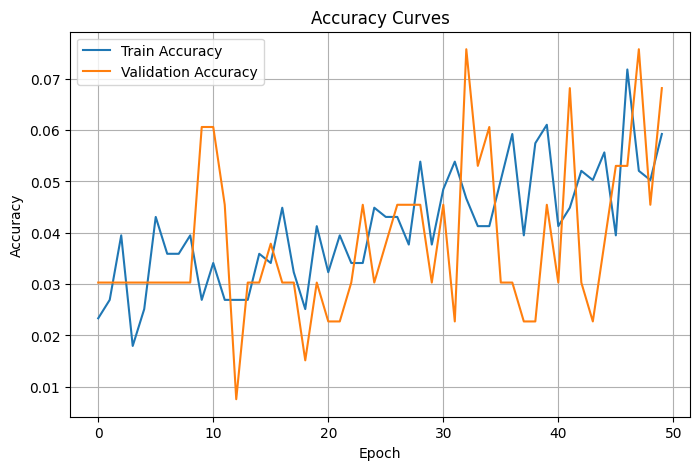

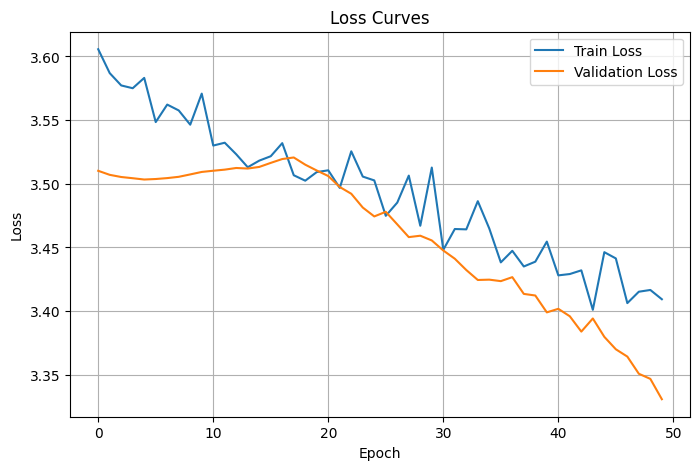

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# **📦 5. Save the Model After Training**

In [ ]:
model.save('efficientnet_bacteria_classifier.h5')


Creating the user GUI for image uploading and geting the model prediction

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.1 MB/s eta 0:00:00


creating the app from streamlit

In [ ]:
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

# Set page title
st.set_page_config(page_title="Bacteria Colony Classifier")

# Load the trained model
@st.cache_resource  # Caches the model after first load
def load_model():
    return tf.keras.models.load_model('efficientnet_bacteria_classifier.h5')

model = load_model()

# Define the class labels - update these based on your dataset folders
class_names = list(train_generator.class_indices.keys())  # Or hardcode: ['A', 'B', 'Healthy']

# Title and instructions
st.title("🧫 Bacteria Colony Classifier")
st.markdown("Upload a bacterial colony image to classify it using your EfficientNet model.")

# Upload file
uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    img = Image.open(uploaded_file).convert('RGB')
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Show result
    st.success(f"### Prediction: {predicted_class} ({confidence:.2f}% confidence)")


2025-05-06 05:32:06.048 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 05:32:06.050 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 05:32:06.353 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-06 05:32:06.354 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 05:32:06.356 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 05:32:06.860 Thread 'Thread-19': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 05:32:06.862 Thread 'Thread-19': missing ScriptRunContext! This warning can be ignored when runnin

Run the user app

In [ ]:
from google.colab import files
files.download('efficientnet_bacteria_classifier.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Install Streamlit on your machine:

bash
Copy
Edit
pip install streamlit
Save the following as bacteria_app.py (same code from above).

Open terminal in the folder where your model and bacteria_app.py are located, and run:

bash
Copy
Edit
streamlit run bacteria_app.py
It will print a local URL like:

nginx
Copy
Edit
Local URL: http://localhost:8501
Open that in your browser to use your app.

✅ Loaded model and 33 classes:
['Acinetobacter.baumanii', 'Actinomyces.israeli', 'Bacteroides.fragilis', 'Bifidobacterium.spp', 'Candida.albicans', 'Clostridium.perfringens', 'Enterococcus.faecalis', 'Enterococcus.faecium', 'Escherichia.coli', 'Fusobacterium', 'Lactobacillus.casei', 'Lactobacillus.crispatus', 'Lactobacillus.delbrueckii', 'Lactobacillus.gasseri', 'Lactobacillus.jehnsenii', 'Lactobacillus.johnsonii', 'Lactobacillus.paracasei', 'Lactobacillus.plantarum', 'Lactobacillus.reuteri', 'Lactobacillus.rhamnosus', 'Lactobacillus.salivarius', 'Listeria.monocytogenes', 'Micrococcus.spp', 'Neisseria.gonorrhoeae', 'Porfyromonas.gingivalis', 'Propionibacterium.acnes', 'Proteus', 'Pseudomonas.aeruginosa', 'Staphylococcus.aureus', 'Staphylococcus.epidermidis', 'Staphylococcus.saprophiticus', 'Streptococcus.agalactiae', 'Veionella']


Saving Lactobacillus.crispatus_0001.tif to Lactobacillus.crispatus_0001.tif


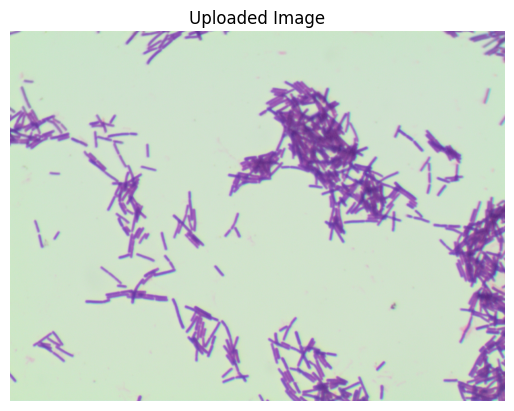

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

🔍 Prediction: **Acinetobacter.baumanii** (5.33% confidence)


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('efficientnet_bacteria_classifier.h5')

# Automatically extract class names from folder names in dataset directory
data_dir = '/content/dataset'
class_names = sorted([
    folder for folder in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, folder))
])

print(f"✅ Loaded model and {len(class_names)} classes:\n{class_names}")

# Upload an image
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and display image
    img = Image.open(filename).convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # Resize and preprocess
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)

    if predicted_index < len(class_names):
        predicted_class = class_names[predicted_index]
    else:
        predicted_class = "Unknown"

    confidence = np.max(predictions) * 100

    # Show result
    print(f"\n🔍 Prediction: **{predicted_class}** ({confidence:.2f}% confidence)")
